In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import chaospy as cp
import numpy as np 
from itertools import product, repeat
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("..")
from src.py.option import AsianOption

In [3]:
def S_t(S_0: float, r: float, sigma: float, t: float, W: float):
    return S_0*np.exp(
        (r-sigma**2*0.5)*t + sigma*W
    )

def geom_asian_payout(S: np.ndarray, K: float):
    d = len(S)
    return np.prod(
        np.maximum(S-K, 0)
    )**(1/d)


def cov_brownian_bridge(s, t):
    """Entry for covariance martix computed according to
    https://math.stackexchange.com/questions/264067/covariance-of-brownian-bridge.
    Where s < t.

    Args:
        s (float): Time s.
        t (float): Time t.

    Returns:
        float: Covariance of Brownian Bridge
    """
    return s*(1-t) #if s <= t else 0

def asian_payout_w(
    d: int,
    S_0: float,
    K,
    r: float,
    sigma: float,
    t: float,
    z: np.ndarray
):
    m = np.log(S_0)+0.5*(r-0.5*sigma**2)*(T+delta_t)#
    V = np.exp(m+sigma/d*np.sum(A@z))
    return np.maximum(V-K, 0)
    

# Asiatische Option  

Als geläufiges Beispiel für Optionspreisbestimmung wird hier eine asiatische Option bewertet.  
Die geschlossene Formel für asiatische Optionen lautet:
$$ V(S,0)=S(0)\gamma \Phi(\beta+\sigma \sqrt{T_1})-Ke^{-rT}\Phi(\beta) $$
mit 
$$ \gamma:= e^{−r(T −T_2 )−σ^2(T_2 −T_1 )/2} $$
$$ \beta:= \frac{
    ln(S(0)/K)+(r-0.5\sigma^2)T_2
}{\sigma \sqrt{T_1}} $$
$$ T_1 := T-\frac{
    d(d-1)(4d+1)}{6d^2}\Delta t $$
$$ T_2 := T-\frac{d-1}{2} \Delta t$$

![](/home/michael/Pictures/euroasianoptionprice.png)

## Beispiel für $d=16$ Zeitschritte, $S(0)=100, \sigma=0.2, r=0.1, T=1, K=100$

In [4]:
from scipy.stats import norm

S_0 = 100
d = 16
dim = 1
a, b = 0,1
y = norm.rvs(size=d)
I = np.linspace(a,b, d, dtype=np.float32, endpoint=False) + 1/d
sigma = 0.2
r = 0.1
T, delta_t = 1, I[1]-I[0]
K = 100
# T_1 = T - (d*(d-1)*(4*d+1))/(6*d**2)*delta_t
# T_2 = T - 0.5*(d-1)*2
# beta = (np.log(S_0/K)+ (r-0.5*sigma**2)*T_1)/(sigma*np.sqrt(T_1))
# gamma = np.exp(-r*(T-T_2)-sigma**2*(T_2-T_1)/2)


st = np.mgrid[1:d+1, 1:d+1]/d
s, t = st
cov = st.min(axis=0)*sigma**2
sigma_g = sigma/np.sqrt(3)
b = 0.5*(r-0.5*sigma_g**2)
d1 = (np.log(S_0/K)+ (b+0.5*sigma_g**2)*T)/(sigma_g*np.sqrt(T))
d2 = d1-sigma_g*np.sqrt(T)
C_G = S_0*np.exp((b-r)*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
print(f"Exact option premium: {C_G:.4f}")

Exact option premium: 6.7700


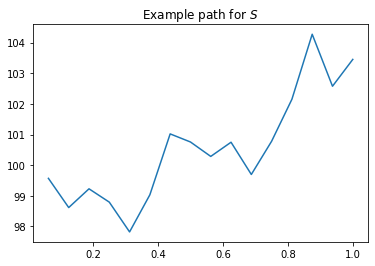

In [5]:
from scipy.stats import norm, multivariate_normal
y = norm.rvs(size=d)
#A = np.sqrt(delta_t)* np.tril(np.ones(d)) # random walk brownian
A = np.linalg.cholesky(cov) # Brownian Bridge brownian
S = S_t(S_0, r, sigma, I, A.dot(y))
plt.plot(I, S)
plt.plot()
plt.title("Example path for $S$")
plt.show()



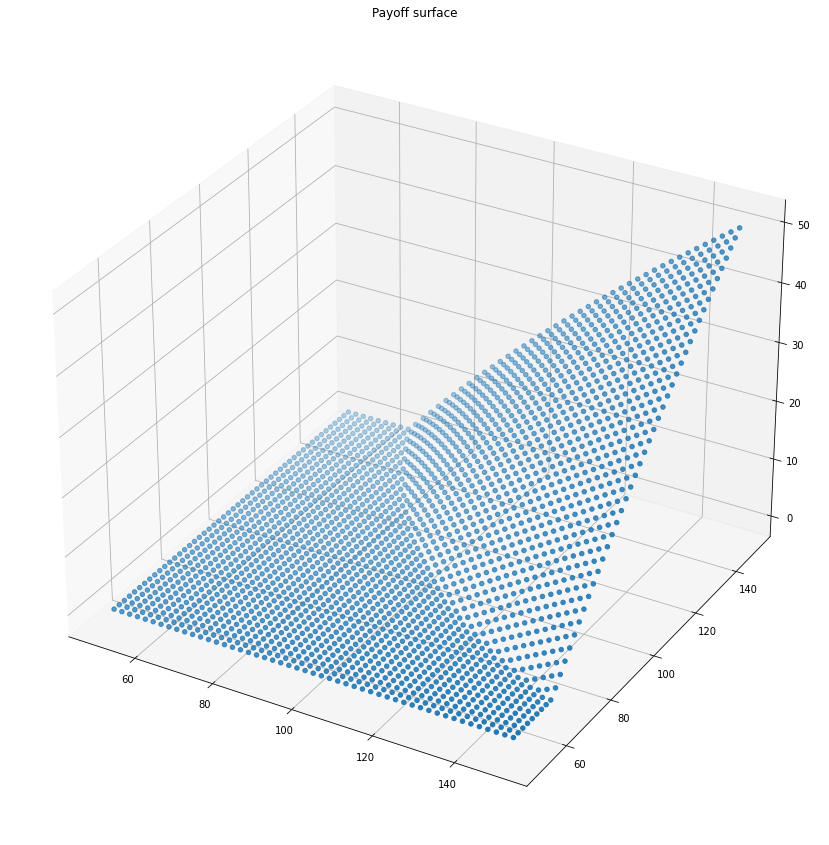

In [9]:
dim = 2
n_points = 50
aop = AsianOption(d=dim)
#ar = np.random.uniform(0+aop.epsilon, 1-aop.epsilon, size=(1000,dim))
ar = np.linspace(50, 150,num=n_points)
gridpoints = np.array(np.meshgrid(ar, ar)).reshape((dim, n_points**2)).T
payoff = aop.payout_func(gridpoints.T)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(gridpoints[:, 0], gridpoints[:, 1], payoff)
ax.set_title("Payoff surface")
plt.show()

In [44]:
import pandas as pd

df = pd.read_table("../adaptive.txt", delim_whitespace=True)
df.head()

,points,error
0,100,0.017655
1,200,0.005346
2,300,0.002445
3,400,0.001516
4,500,0.001237


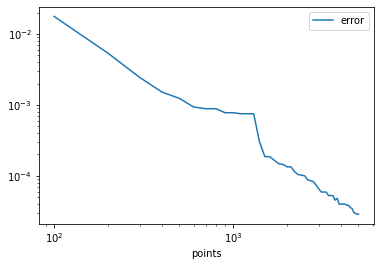

In [43]:
df.plot(x="points", y="error")
plt.yscale("log")
plt.xscale("log")
plt.show()